In [1]:
import torch
import numpy as np
from tqdm.notebook import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys
import os

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.reshape_data import *
from data.mock_data import *

#spikes, behavior, coordinates, df, stimulus = load_data()
#spikes, coordinates, times = load_data_thijs()

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
'''
to dump:

path = os.path.dirname(os.getcwd())
pickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))

to load:

check1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))
'''

"\nto dump:\n\npath = os.path.dirname(os.getcwd())\npickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))\n\nto load:\n\ncheck1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))\n"

In [6]:
train_data, test_data = generate_train_test(voxel_spike, train_data_ratio=0.75, mode=1)
train_data.shape



torch.Size([93, 75, 28])

Train RTRBM

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:08<00:00,  1.89s/it]


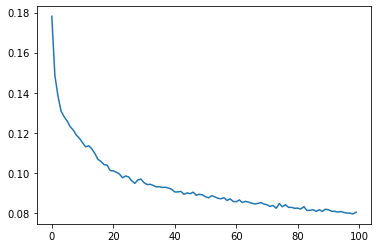

In [7]:
N_H = 100
rtrbm = RTRBM(train_data, N_H=N_H, device="cpu")
rtrbm.learn(n_epochs=100, batchsize=1, lr=1e-3, sp=1e-4, x=2)
plt.plot(rtrbm.errors)

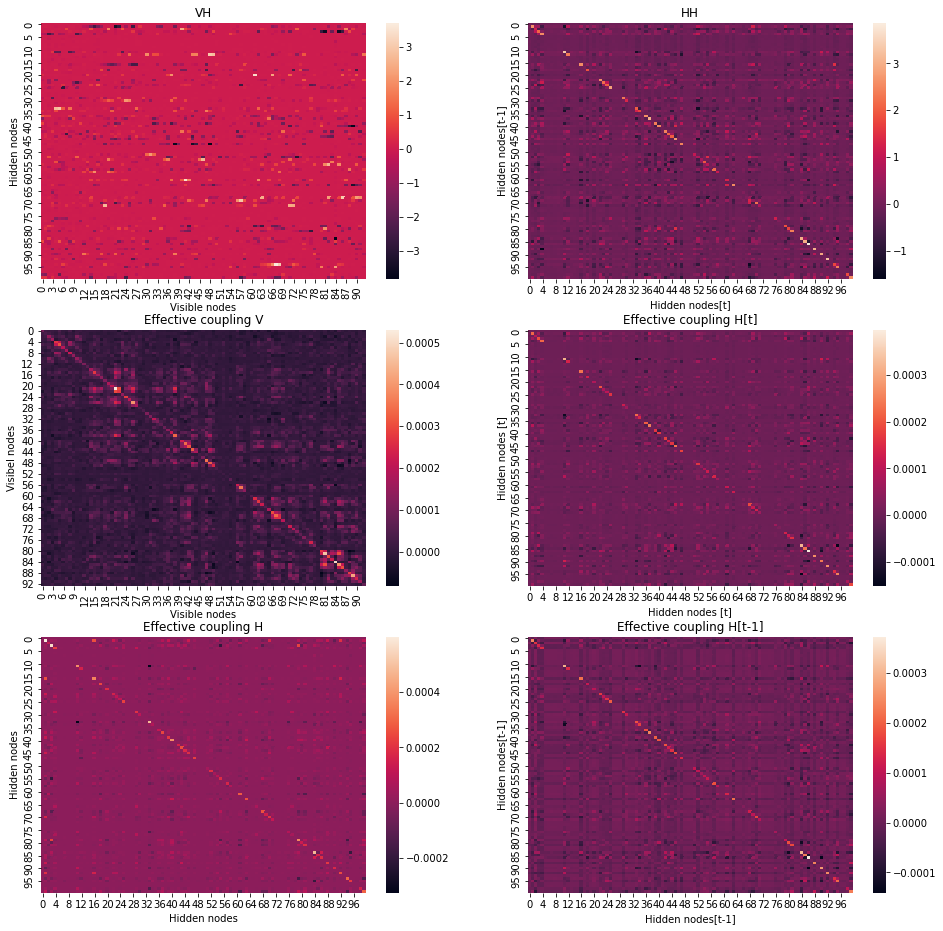

In [8]:
N_V, T, num_samples = train_data.shape
data = torch.zeros(N_V, T * num_samples)
for i in range(num_samples):
    data[:, T * i:T * (i + 1)] = train_data[:, :, i]
    
plot_effective_coupling_VH_HH(rtrbm.W, rtrbm.W_acc, data, rtrbm.visible_to_expected_hidden(data.float()))

Train RBM

D:\RU\OneDrive\Intern\rtrbm_master\boltzmann_machines\RBM_centered.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mu_V = torch.tensor(torch.mean(self.data, 1), dtype=self.dtype, device=self.device)
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:13<00:00,  3.13s/it]


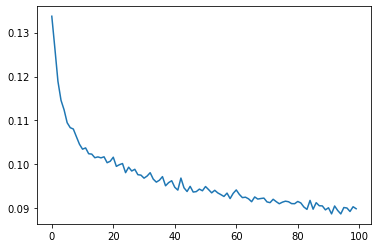

In [27]:
rbm = RBM(train_data, N_H=N_H, device="cpu")
rbm.learn(n_epochs=100, batchsize=100, lr_offset=0.2, lr=1e-2, mom=0.9, wc=0, sp=0.02, x=2)
plt.plot(rbm.errors)

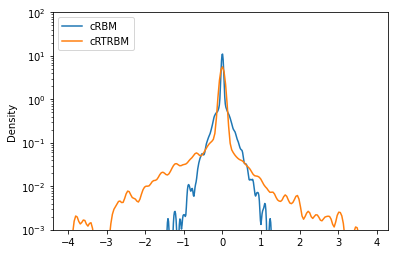

In [29]:
plot_weights_log_distribution_compare(rbm.W, rtrbm.W, label1='cRBM', label2='cRTRBM')

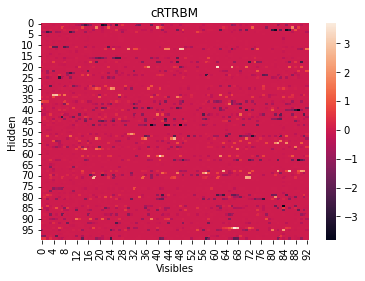

Text(0.5, 1.0, 'cRBM')

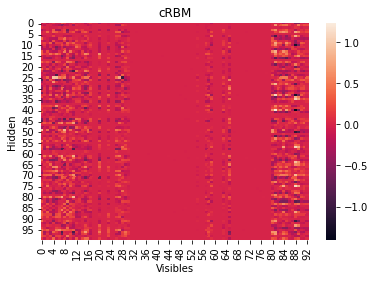

In [31]:
sns.heatmap(rtrbm.W)
plt.xlabel('Visibles')
plt.ylabel('Hidden')
plt.title('cRTRBM')

plt.show()
sns.heatmap(rbm.W)
plt.xlabel('Visibles')
plt.ylabel('Hidden')
plt.title('cRBM')

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:04<00:00,  6.09it/s]


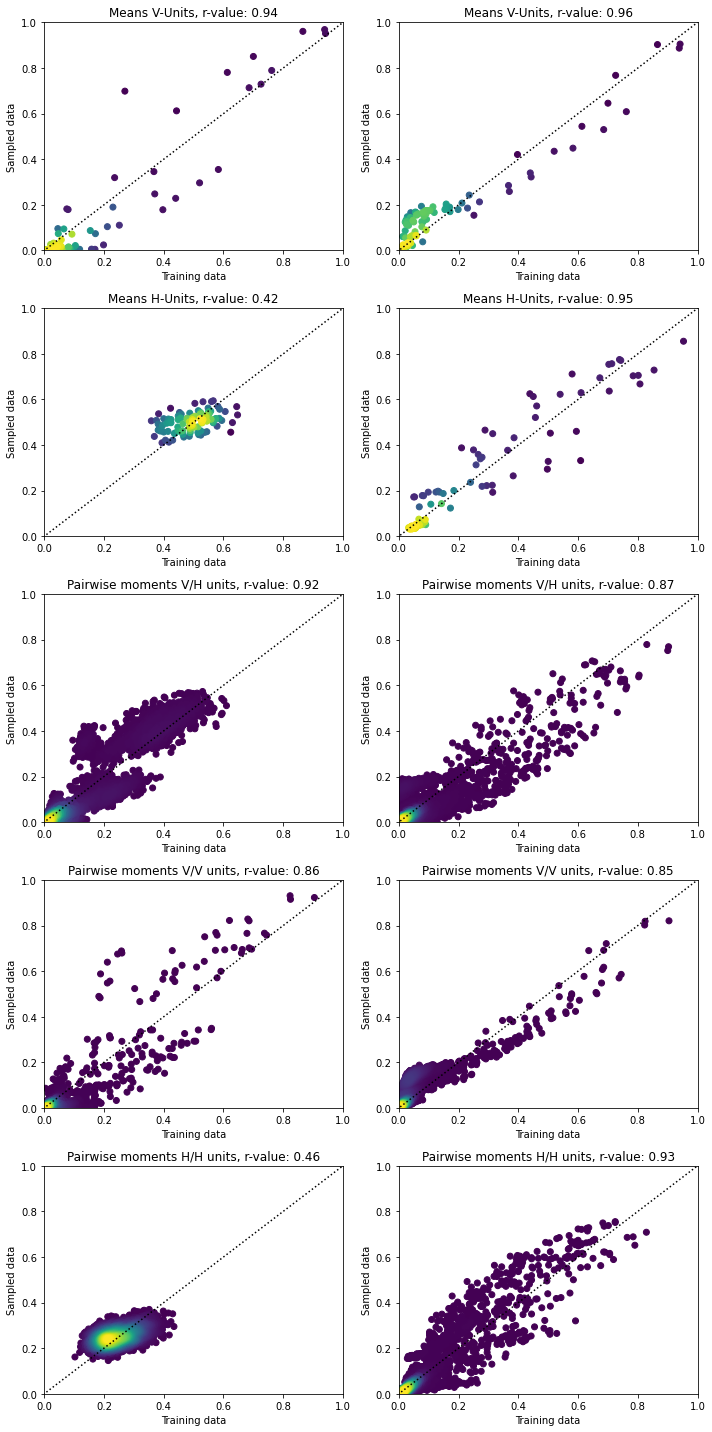

In [32]:
n_batches = train_data.shape[2]
plot_compare_moments(rbm, rtrbm, train_data, test_data, MC_chains=n_batches, chain=50, pre_gibbs_k=10, gibbs_k=20, config_mode=2)

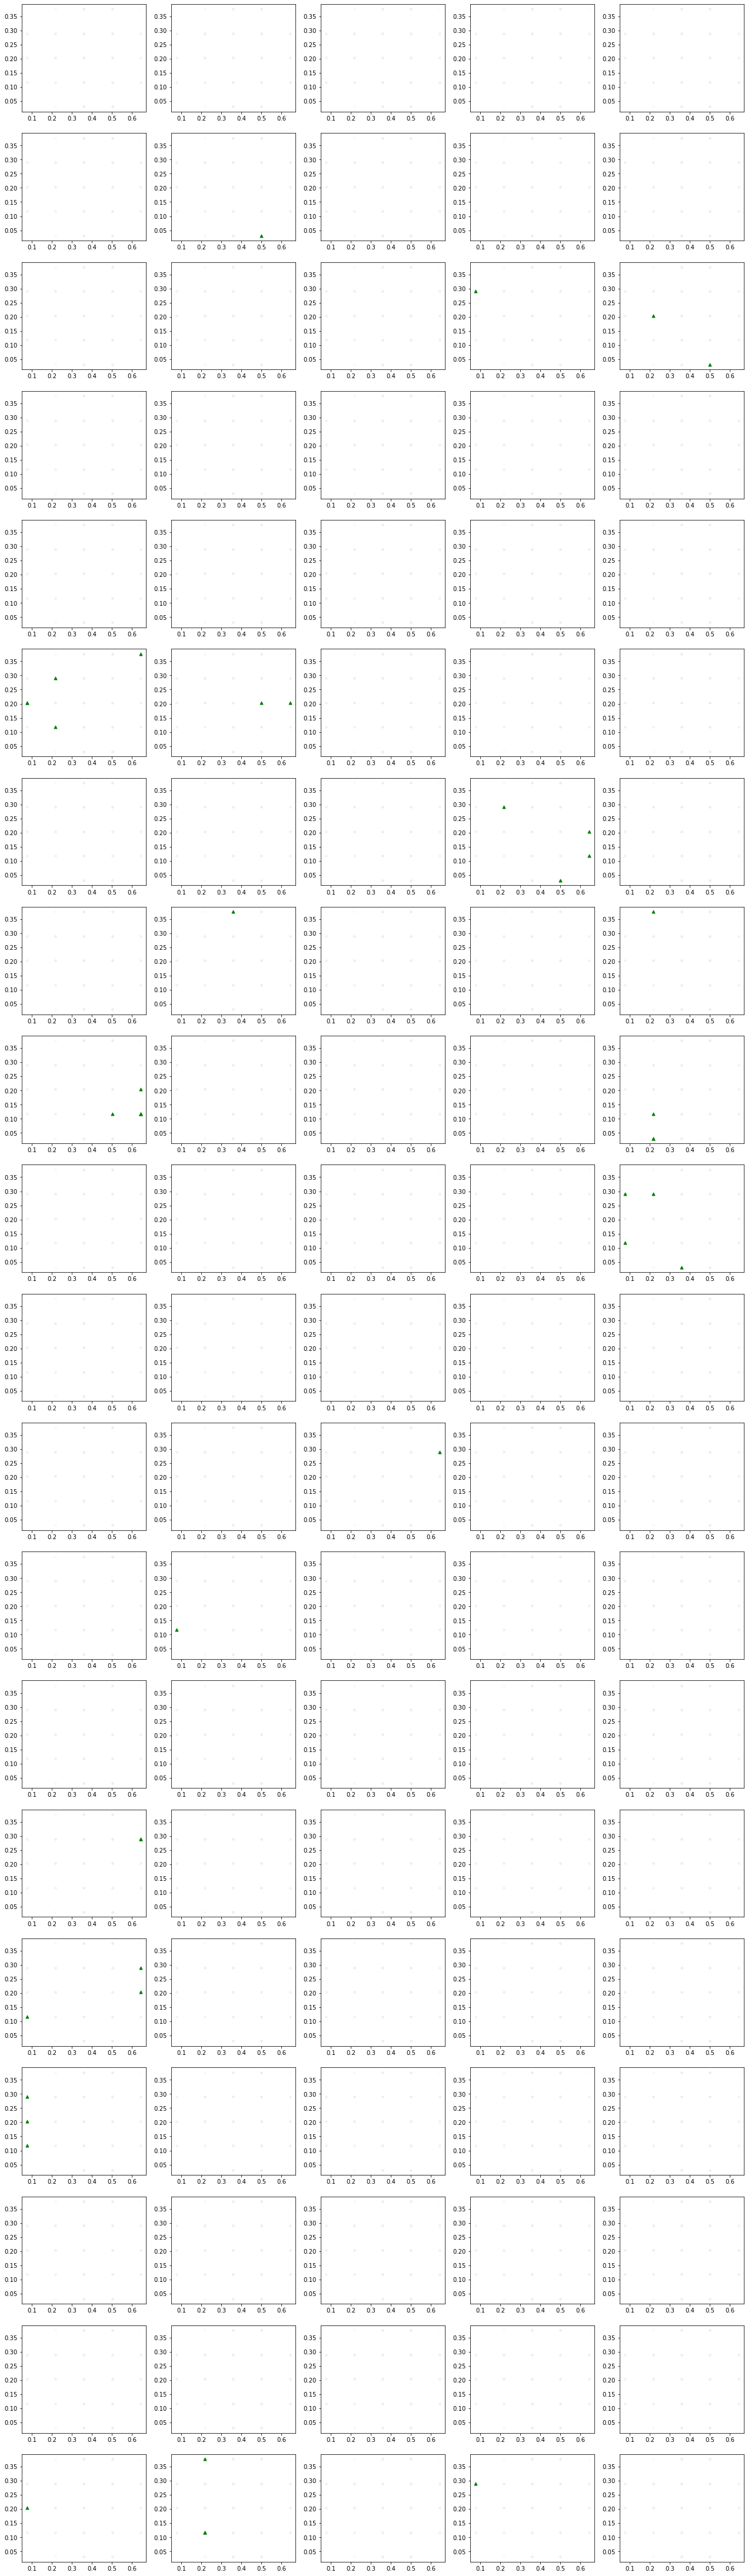

In [33]:
VH = rbm.W
coordinates = voxel_xyz
fig, ax = plt.subplots(20, 5, figsize=(22, 80))
max_hidden_connection = torch.max(VH, 0)[1]
strong_thresh = 0.2 * torch.std(VH)
h = 0
for i in range(20):
    for j in range(5):
        idx_p = (max_hidden_connection==h)*(VH[h,:] >  strong_thresh)
        idx_m = (max_hidden_connection==h)*(VH[h,:] < -strong_thresh)
        #idx_not_p = (max_hidden_connection==h)*((VH[h,:] <=  strong_thresh) & (VH[h,:]>0))
        #idx_not_m = (max_hidden_connection==h)*((VH[h,:] >= -strong_thresh) & (VH[h,:]<0))

        ax[i,j].scatter(coordinates[:,0], coordinates[:,1], s=15, color = 'blue', alpha=0.01)

        ax[i,j].scatter(coordinates[idx_p,0], coordinates[idx_p,1], s=25, color = 'green', marker='^')
        ax[i,j].scatter(coordinates[idx_m,0], coordinates[idx_m,1], s=25, color = 'red', marker="v")

        #ax[i,j].scatter(coordinates[idx_not_p,0], coordinates[idx_not_p,1], s=25, color = 'red', marker='^', alpha=0.3)
        #ax[i,j].scatter(coordinates[idx_not_m,0], coordinates[idx_not_m,1], s=25, color = 'red', marker="v", alpha=0.3)

        h +=1
            
    #mpl.style.use('seaborn')

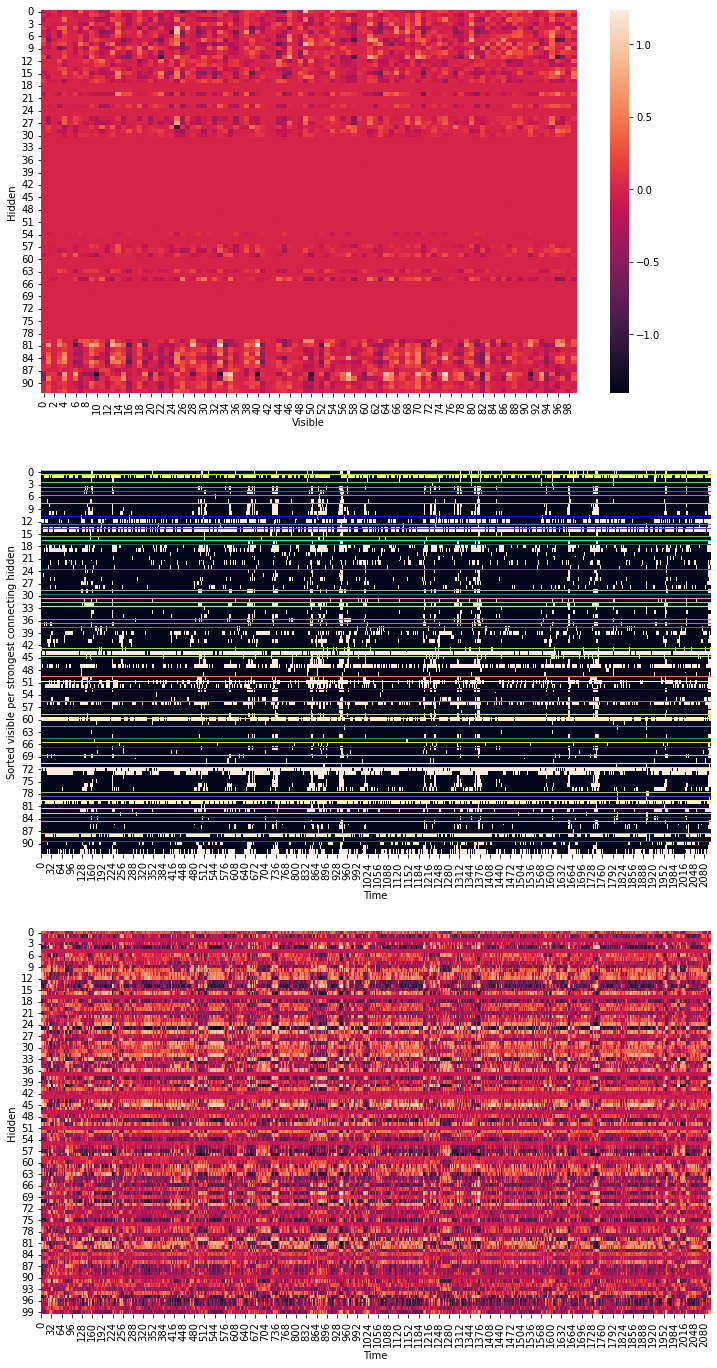

In [34]:
rt = torch.zeros([N_H, rbm.num_samples])
for t in range(rbm.num_samples):
    rt[:,t], _ = rbm.visible_to_hidden(rbm.data[:,t])
    
plot_spikes_grouped_by_HU(rbm.W, rbm.data, rt)

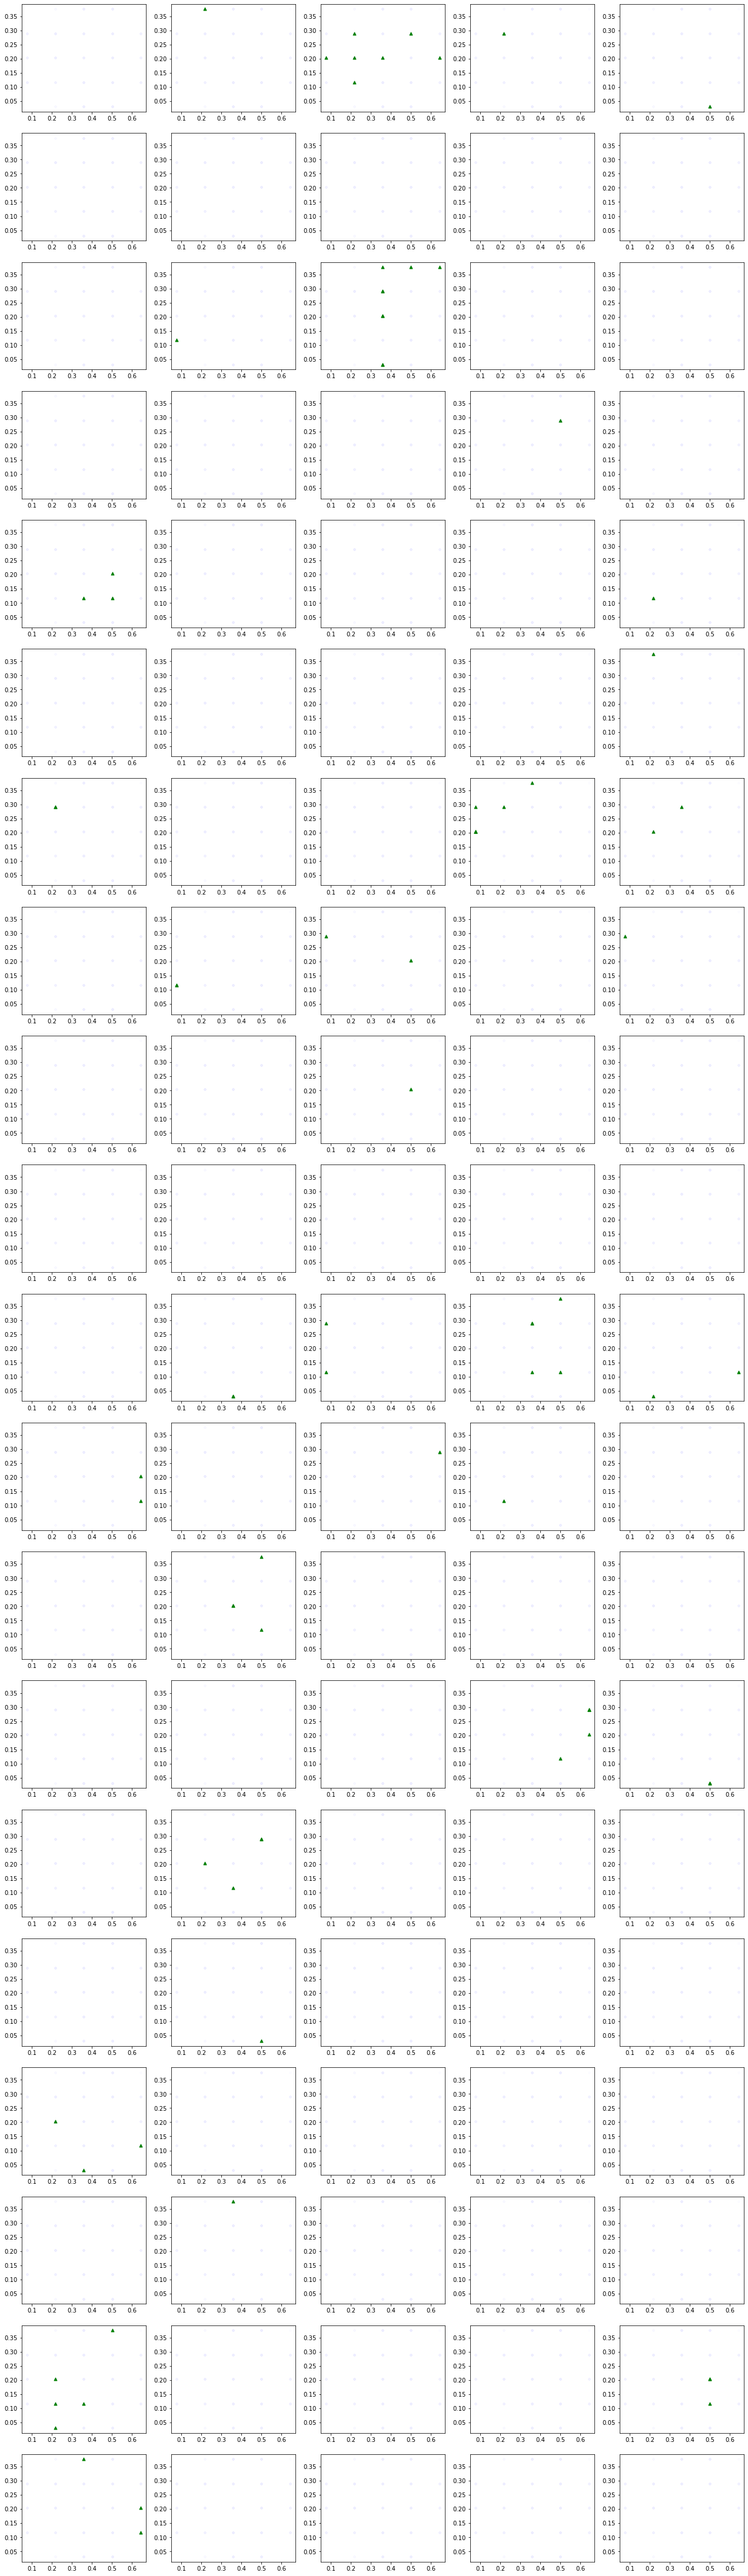

In [35]:
VH = rtrbm.W
coordinates = voxel_xyz
fig, ax = plt.subplots(20, 5, figsize=(22, 80))
max_hidden_connection = torch.max(VH, 0)[1]
strong_thresh = 0.2 * torch.std(VH)
h = 0
for i in range(20):
    for j in range(5):
        idx_p = (max_hidden_connection==h)*(VH[h,:] >  strong_thresh)
        idx_m = (max_hidden_connection==h)*(VH[h,:] < -strong_thresh)
        #idx_not_p = (max_hidden_connection==h)*((VH[h,:] <=  strong_thresh) & (VH[h,:]>0))
        #idx_not_m = (max_hidden_connection==h)*((VH[h,:] >= -strong_thresh) & (VH[h,:]<0))

        ax[i,j].scatter(coordinates[:,0], coordinates[:,1], s=15, color = 'blue', alpha=0.01)

        ax[i,j].scatter(coordinates[idx_p,0], coordinates[idx_p,1], s=25, color = 'green', marker='^')
        ax[i,j].scatter(coordinates[idx_m,0], coordinates[idx_m,1], s=25, color = 'red', marker="v")

        #ax[i,j].scatter(coordinates[idx_not_p,0], coordinates[idx_not_p,1], s=25, color = 'red', marker='^', alpha=0.3)
        #ax[i,j].scatter(coordinates[idx_not_m,0], coordinates[idx_not_m,1], s=25, color = 'red', marker="v", alpha=0.3)

        h +=1
            
    #mpl.style.use('seaborn')

In [ ]:
rt = rtrbm.visible_to_expected_hidden(rbm.data)
plot_spikes_grouped_by_HU(rtrbm.W, rbm.data, rt)

In [ ]:
plot_compare_moments(rbm, rtrbm, train_data, test_data, MC_chains=n_batches, chain=50, pre_gibbs_k=100, gibbs_k=20, config_mode=2)

In [24]:
N_H = 100
rtrbm = RTRBM(train_data, N_H=N_H, device="cpu")
rtrbm.learn(n_epochs=500, batchsize=1, lr=1e-3, CDk=5, mom=0, wc=0, sp=None, PCD=False)

rbm = RBM(train_data, N_H=N_H, device="cpu")
rbm.learn(n_epochs=500, batchsize=1, lr=1e-3, CDk=5, mom=0, wc=0, sp=None, PCD=False)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [04:40<00:00,  1.78it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [04:04<00:00,  1.23it/s]


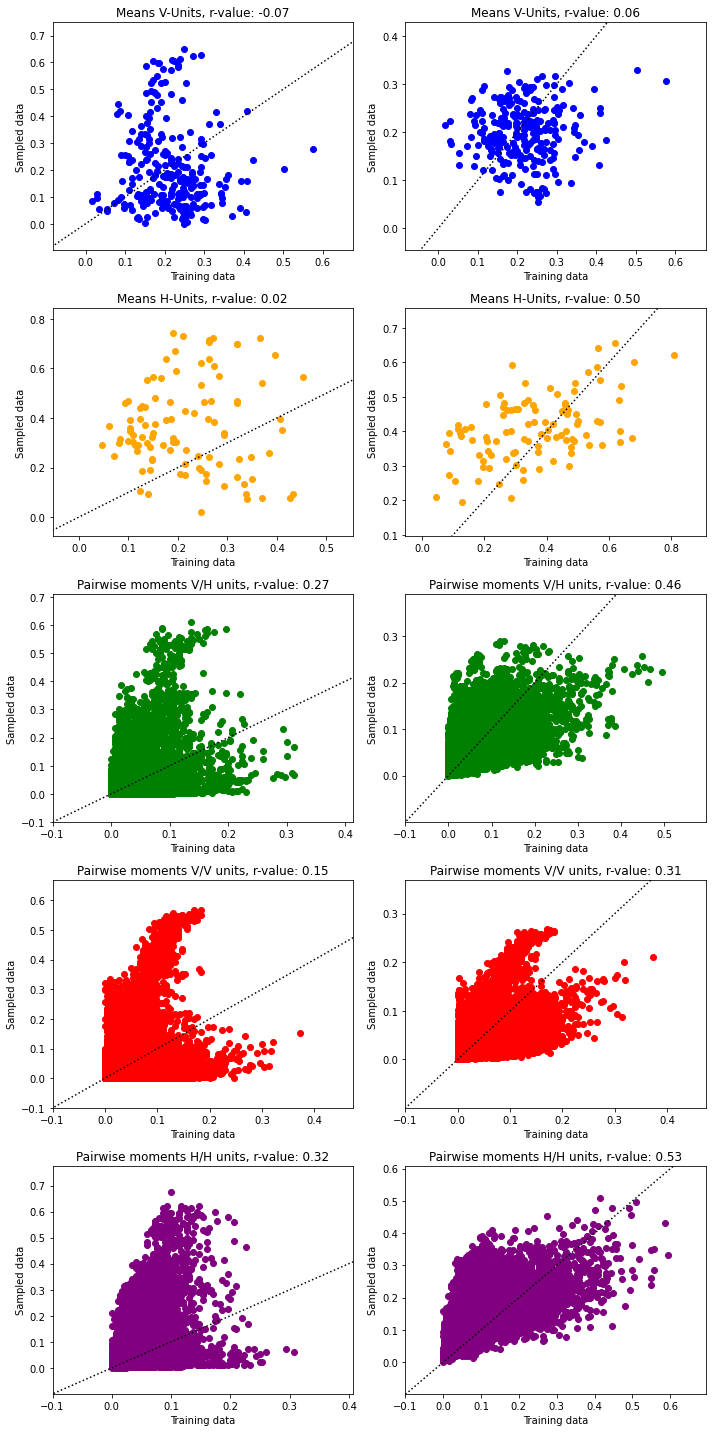

In [25]:
plot_compare_moments(rbm, rtrbm, train_data, test_data, MC_chains=300, chain=50, pre_gibbs_k=100, gibbs_k=20)

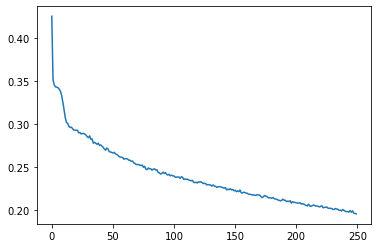

In [23]:
plt.plot(rtrbm.errors)

In [41]:
N_V, N_H, T = 16, 8, 32
data = create_BB(N_V=N_V, T=T, n_samples=24, width_vec=[4, 5, 6, 7], velocity_vec=[2, 3], boundary=False)
train_data = torch.tensor(data[:,:,:20], dtype=torch.float)
test_data = torch.tensor(data[:,:,21:], dtype=torch.float)

<ipython-input-41-068cebd3c993>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(data[:,:,:20], dtype=torch.float)
<ipython-input-41-068cebd3c993>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.tensor(data[:,:,21:], dtype=torch.float)


In [42]:
rtrbm = RTRBM(train_data, N_H=N_H, device="cpu")
rtrbm.learn(n_epochs=100, batchsize=1, lr=1e-3, CDk=5, mom=0, wc=0, sp=None, PCD=False)

rbm = RBM(train_data, N_H=N_H, device="cpu")
rbm.learn(n_epochs=100, batchsize=1, lr=1e-3, CDk=5, mom=0, wc=0, sp=None, PCD=False)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.38it/s]


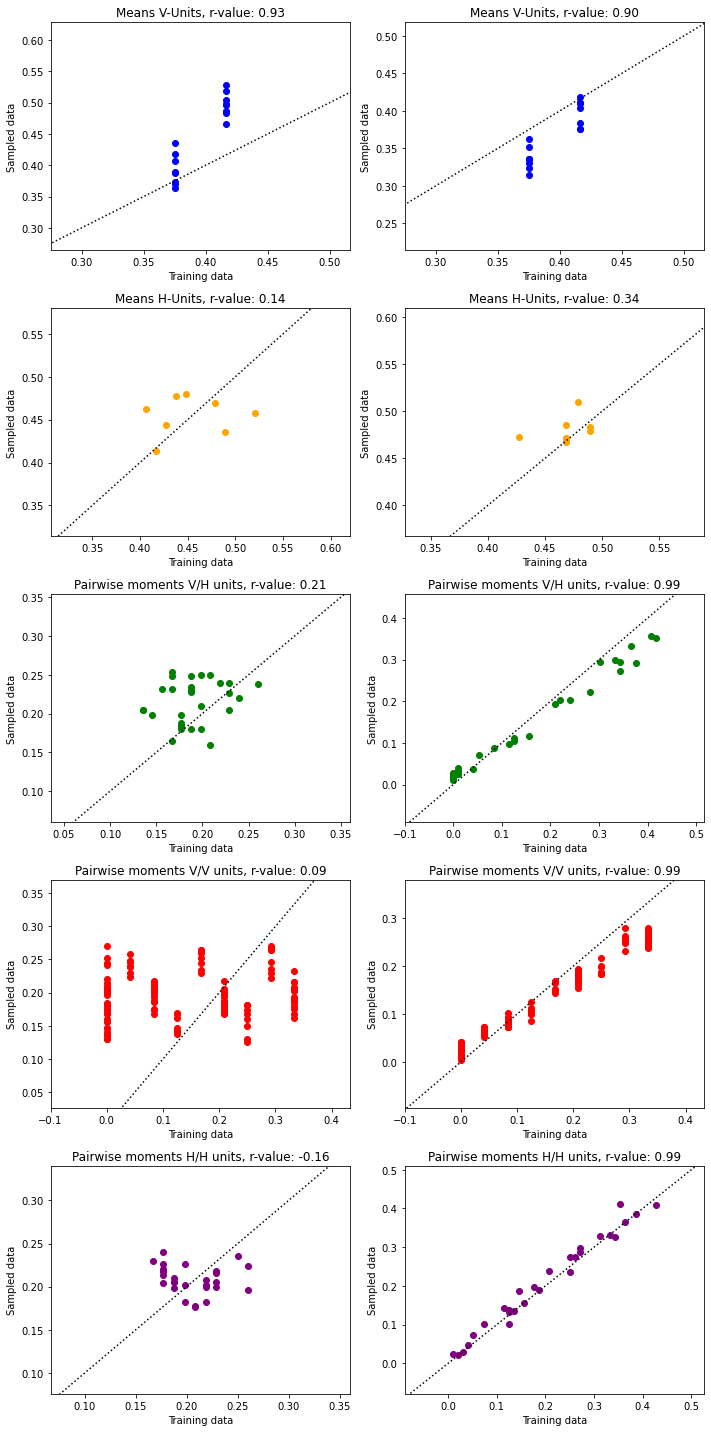

In [44]:
plot_compare_moments(rbm, rtrbm, train_data, test_data, MC_chains=10, chain=50, pre_gibbs_k=0, gibbs_k=20)

In [38]:
def plot_compare_moments(rbm, rtrbm, train_data, test_data, MC_chains=300, chain=50, pre_gibbs_k=50, gibbs_k=20):
    # catenate train and test data
    a = train_data.shape
    if torch.tensor(a).shape[0] == 3:
        V_train = train_data.reshape(a[0], a[1] * a[2])
    elif torch.tensor(a).shape[0] == 2:
        V_train = train_data
    s = test_data.shape
    if torch.tensor(s).shape[0] == 3:
        V_test = test_data.reshape(s[0], s[1] * s[2])
    elif torch.tensor(s).shape[0] == 2:
        V_test = test_data

    # create figure
    fig, axes = plt.subplots(5, 2, figsize=(10, 20))

    for i, machine in enumerate([rbm, rtrbm]):

        for MC_chain in tqdm(range(MC_chains)):
            random_train_config = V_train[:, torch.randint(0, V_train.shape[1], (1,))]

            v_sampled, h_sampled = machine.sample(random_train_config.T, chain=chain, pre_gibbs_k=pre_gibbs_k, gibbs_k=gibbs_k, mode=1,
                                                  disable_tqdm=True)

            if MC_chain == 0:
                v_samples = v_sampled.detach()
                h_samples = h_sampled.detach()
            else:
                v_samples = torch.cat((v_samples, v_sampled), 1)
                h_samples = torch.cat((h_samples, h_sampled), 1)

        if machine is rbm:
            _, H_test = rbm.visible_to_hidden(V_test.T)
            H_test = H_test.T
        elif machine is rtrbm:
            rtrbm_H_test = torch.zeros(rtrbm.N_H, s[1], s[2])
            for j in range(s[2]):
                r = rtrbm.visible_to_expected_hidden(test_data[:, :, j], AF=torch.sigmoid)
                _, rtrbm_H_test[:, :, j] = rtrbm.visible_to_hidden(test_data[:, :, j], r)
            H_test = rtrbm_H_test.view(rtrbm.N_H, s[1] * s[2]).detach()

        means_V_data, means_V_samples, means_H_data, means_H_samples, pw_VV_data, pw_VV_samples, pw_HH_data, \
        pw_HH_samples, pw_VH_data, pw_VH_samples, r_V, r_H, r_VV, r_VH, r_HH = \
            moments(V_test, H_test, v_samples, h_samples)

        ax = axes[0, i]
        ax.plot(means_V_data, means_V_samples, 'bo')
        ax.plot([-1, 1], [-1, 1], ':', color='k')
        ax.set_xlim([torch.min(means_V_data) - 0.1, torch.max(means_V_data) + 0.1])
        ax.set_ylim([torch.min(means_V_samples) - 0.1, torch.max(means_V_samples) + 0.1])
        # ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel("Training data")
        ax.set_ylabel("Sampled data")
        ax.set_title("Means V-Units, r-value: {:.2f}".format(r_V))

        ax = axes[1, i]
        ax.plot(means_H_data, means_H_samples, 'o', color='orange')
        ax.plot([-1, 1], [-1, 1], ':', color='k')
        ax.set_xlim([torch.min(means_H_data) - 0.1, torch.max(means_H_data) + 0.1])
        ax.set_ylim([torch.min(means_H_samples) - 0.1, torch.max(means_H_samples) + 0.1])
        # ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel("Training data")
        ax.set_ylabel("Sampled data")
        ax.set_title("Means H-Units, r-value: {:.2f}".format(r_H))

        ax = axes[2, i]
        ax.plot(pw_VH_data, pw_VH_samples, 'go')
        ax.plot([-1, 1], [-1, 1], ':', color='k')
        ax.set_xlim([torch.min(pw_VH_data) - 0.1, torch.max(pw_VH_data) + 0.1])
        ax.set_ylim([torch.min(pw_VH_samples) - 0.1, torch.max(pw_VH_samples) + 0.1])
        # ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel("Training data")
        ax.set_ylabel("Sampled data")
        ax.set_title("Pairwise moments V/H units, r-value: {:.2f}".format(r_VH))

        ax = axes[3, i]
        ax.plot(pw_VV_data, pw_VV_samples, 'ro')
        ax.plot([-1, 1], [-1, 1], ':', color='k')
        ax.set_xlim([torch.min(pw_VV_data) - 0.1, torch.max(pw_VV_data) + 0.1])
        ax.set_ylim([torch.min(pw_VV_samples) - 0.1, torch.max(pw_VV_samples) + 0.1])
        # ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel("Training data")
        ax.set_ylabel("Sampled data")
        ax.set_title("Pairwise moments V/V units, r-value: {:.2f}".format(r_VV))

        ax = axes[4, i]
        ax.plot(pw_HH_data, pw_HH_samples, 'o', color='purple')
        ax.plot([-1, 1], [-1, 1], ':', color='k')
        ax.set_xlim([torch.min(pw_HH_data) - 0.1, torch.max(pw_HH_data) + 0.1])
        ax.set_ylim([torch.min(pw_HH_samples) - 0.1, torch.max(pw_HH_samples) + 0.1])
        # ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel("Training data")
        ax.set_ylabel("Sampled data")
        ax.set_title("Pairwise moments H/H units, r-value: {:.2f}".format(r_HH))

    fig.tight_layout()
    plt.show()

    return

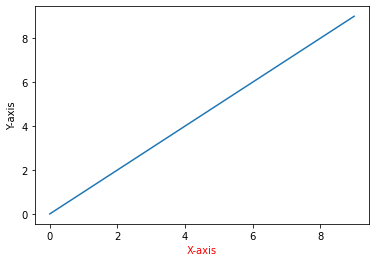

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(10))
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

#ax.spines['bottom'].set_color('red')
#ax.spines['top'].set_color('red')
ax.xaxis.label.set_color('red')
#ax.tick_params(axis='x', colors='red')

plt.show()